# Sentiment analysis of clothing reviews

Women’s Clothing E-Commerce dataset contains a total of 23486 rows and 10 feature variables, where each row represents a customer review. For the sentiment analysis, we will only use the 'Review text' as learning feature and for evaluation, we will use the 'Recommended IND' target variable.  

As suggested by Jeremy, we will first train the model to understand English (predicting next word in sequence) and then we will use this model's encoder in the sentiment analysis model. (Might also try training sentiment analysis without learning English first)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *
from fastai.plots import *

import dill as pickle
import spacy

from functools import partial
import pathlib

from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'PIL'

In [ ]:
PATH = 'data/'
fname = 'Womens Clothing E-Commerce Reviews.csv'

### Basic data analysis

In [3]:
reviews = pd.read_csv(f'{PATH}{fname}'); reviews.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

We don't need all the features, so we will delete all except ID, text and recommended (dependent variable)

In [4]:
reviews = reviews[['Clothing ID', 'Review Text', 'Recommended IND']]; reviews.head(5)

Clothing ID                                        Review Text  \
0          767  Absolutely wonderful - silky and sexy and comf...   
1         1080  Love this dress!  it's sooo pretty.  i happene...   
2         1077  I had such high hopes for this dress and reall...   
3         1049  I love, love, love this jumpsuit. it's fun, fl...   
4          847  This shirt is very flattering to all due to th...   

   Recommended IND  
0                1  
1                1  
2                0  
3                1  
4                1

In [5]:
# Get number of words in each review and analyse distribution
reviews['Review Text'].apply(lambda x: str(x).split()).apply(len).describe()

count    23486.000000
mean        58.066848
std         30.107737
min          1.000000
25%         34.000000
50%         57.000000
75%         87.000000
max        115.000000
Name: Review Text, dtype: float64

Here we can see that the corpus isn't really that big (23,486 * 58 = 1,362,188 words)  and we are dealing with pretty short pieces of text too. I am currently not sure, how to adjust model / hyperparameters according to these facts, so I will stick with defaults given by Jeremy. It might be good idea to apply the model to bigger corpus first to learn English and after that use this dataset. I will try and benchmark that approach later.

In [6]:
reviews['Recommended IND'].describe()

count    23486.000000
mean         0.822362
std          0.382216
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Recommended IND, dtype: float64

80% of reviews are from people, who recommend the product. This means, that we will have to think about our evaluation metric. We should probably analyse our results too (confusion matrix).

### Metrics  
I decided to use Kappa statistic to compensate for imbalance in distribution of target values.

In [7]:
def kappa(pred, target, exp_acc=0.5):
    correct = np.shape(np.where(np.equal(pred,target)))[1]
    accuracy = correct / len(pred)
    return (accuracy - exp_acc) / (1 - exp_acc)

### Preparing data

Split dataset into train and validation sets.

In [8]:
val_idxs = get_cv_idxs(len(reviews))

In [9]:
train_df = reviews.drop(val_idxs)
val_df = reviews.iloc[val_idxs]

### Training the model to understand English

Choosing smaller bptt, for the reasons stated above.

In [10]:
bs=64
bptt=20

In [11]:
spacy_tok = spacy.load('en')
' '.join([sent.string.strip() for sent in spacy_tok(train_df['Review Text'].iloc[0])])

'Absolutely wonderful - silky and sexy and comfortable'

In [12]:
TEXT = data.Field(lower=True, tokenize="spacy")

In [13]:
md = LanguageModelData.from_dataframes(PATH, TEXT, 'Review Text', train_df, val_df, bs=bs, bptt=bptt, min_freq=10)

In [67]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Using the default values

In [14]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [15]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [16]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

 82%|███████████████████████████████████████████████████████▊            | 846/1031 [00:44<00:09, 19.07it/s, loss=18.1]

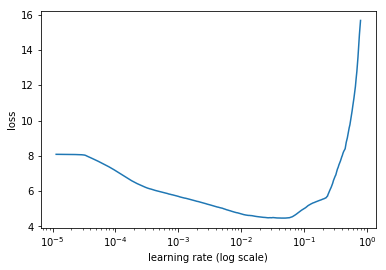

In [72]:
lrf=learner.lr_find()
learner.sched.plot()

In [90]:
lr=2e-3

In [91]:
learner.fit(lr, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      4.058051   3.994829  
    1      3.595222   3.536992                                                                                         
    2      3.457781   3.439728                                                                                         
    3      3.411312   3.359637                                                                                         
    4      3.270802   3.27712                                                                                          
    5      3.167452   3.229313                                                                                         
    6      3.150808   3.220309                                                                                         
    7      3.252263   3.246603                                                                                         
    8  

[array([3.17988])]

In [92]:
learner.save('adam1')
learner.save_encoder('adam1_enc')

In [18]:
learner.load('adam1')
learner.load_encoder('adam1_enc')

 92%|██████████████████████████████████████████████████████████████▋     | 950/1031 [00:57<00:04, 16.42it/s, loss=11.2]

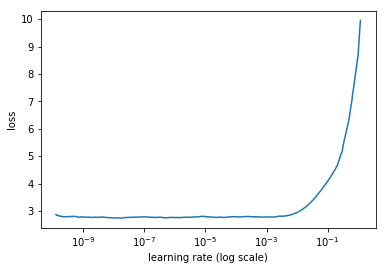

 92%|██████████████████████████████████████████████████████████████▋     | 950/1031 [01:08<00:05, 13.86it/s, loss=11.2]

In [85]:
learner.lr_find(start_lr=1e-10)
learner.sched.plot()

Looks like further training wouldn't improve performance of the model, so we won't train it any further.

In [94]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

### Test model on word prediction

We will try out our model to see if it doesn't have problem to work with text.  
Let's take the first review in validation set.

In [105]:
samp = val_df['Review Text'].iloc[0]; samp

'I agree with the other reviewer that the color isn\'t as pink in person and more subtle. my thoughts below on some other things:\r\n__________\r\npros:\r\n- pockets! makes it so fun and chic with the overall style.\r\n- the material is lovely and breathable. i didn\'t find it sheer at all! of course, i didn\'t wear it outside the dressing room. the material is thicker but it hangs on the body well.\r\n- runs "mostly" tts. i only tried on the medium and it fit everywhere being slightly tighter in the chest. i'

It needs to be tokenized (string -> list of tokens) and numericalized with respect to vocabulary that the model was trained on (list of tokens -> list of numbers)

In [109]:
m = learner.model
s = [spacy_tok(samp)]
t = TEXT.numericalize(s)
' '.join([sent.string.strip() for sent in s[0]])

'I agree with the other reviewer that the color is n\'t as pink in person and more subtle . my thoughts below on some other things :  _ _ _ _ _ _ _ _ _ _  pros :  - pockets ! makes it so fun and chic with the overall style .  - the material is lovely and breathable . i did n\'t find it sheer at all ! of course , i did n\'t wear it outside the dressing room . the material is thicker but it hangs on the body well .  - runs " mostly " tts . i only tried on the medium and it fit everywhere being slightly tighter in the chest . i'

We also have to change some parameters of model

In [110]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Now we will get top 10 predictions (as numbers) and we will convert them to strings. 

In [111]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', '<', 'in', ',', 'and', '.', 'dress', 'with', 'i', '(']

Let's try generating more text.

In [114]:
print(samp,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

I agree with the other reviewer that the color isn't as pink in person and more subtle. my thoughts below on some other things:
__________
pros:
- pockets! makes it so fun and chic with the overall style.
- the material is lovely and breathable. i didn't find it sheer at all! of course, i didn't wear it outside the dressing room. the material is thicker but it hangs on the body well.
- runs "mostly" tts. i only tried on the medium and it fit everywhere being slightly tighter in the chest. i 

love the colors and the design . i am a size 4 and the small fit perfectly . < eos > i love this dress ! it 's so soft and comfortable . i love the colors and the design . i am a size 4 and the small fit ...


The model seems to ignore certain facts mentioned in text and starts repeating itself after a while. It has guessed the sentiment right, but that could be caused by the fact, that 80% of data are positive reviews. However, it seem's it has no problem working with English, which is what we want.

### Sentiment analysis

Now we are going to use the same vocabulary and encoder our previous model used. We start by splitting train and validation sets by labels. We will save them as .txt files.

In [55]:
train_df_0 = train_df[train_df['Recommended IND'] == 0]
train_df_1 = train_df[train_df['Recommended IND'] == 1]
val_df_0 = val_df[val_df['Recommended IND'] == 0]
val_df_1 = val_df[val_df['Recommended IND'] == 1]

In [105]:
for i,r in train_df_0.iterrows():
    with open(f"{PATH}train/0/{i}.txt","w+",encoding="utf-8") as f:
        f.write(str(r['Review Text']))        
for i,r in train_df_1.iterrows():
    with open(f"{PATH}train/1/{i}.txt","w+",encoding="utf-8") as f:
        f.write(str(r['Review Text']))
for i,r in val_df_0.iterrows():
    with open(f"{PATH}validation/0/{i}.txt","w+",encoding="utf-8") as f:
        f.write(str(r['Review Text']))
for i,r in val_df_1.iterrows():
    with open(f"{PATH}validation/1/{i}.txt","w+",encoding="utf-8") as f:
        f.write(str(r['Review Text']))

Now we need to create our own dataset class, which we will later instantiate. 

In [18]:
class ClothingDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in ['1', '0']:
            for fname in glob(os.path.join(path, label, '*.txt')):
                with open(fname, 'r') as f: text = f.readline()
                examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', validation='validation', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=validation, test=None, **kwargs)

In [115]:
??TextData

In [19]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))
CLOT_LABEL = data.Field(sequential=False, use_vocab=False)

In [20]:
splits = ClothingDataset.splits(TEXT, CLOT_LABEL, PATH, train='train', validation='validation')

In [21]:
md2 = TextData.from_splits(PATH, splits, bs)

In [22]:
m2 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m2.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m2.load_encoder(f'adam1_enc')

 52%|███████████████████████████████████▉                                 | 153/294 [00:47<00:43,  3.23it/s, loss=2.66]

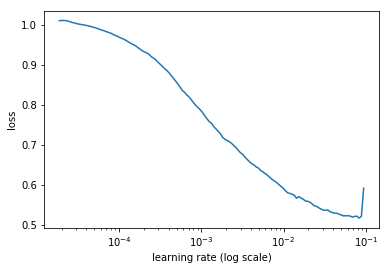

In [117]:
m2.lr_find(end_lr=1000)
m2.sched.plot()

In [24]:
m2.clip=25.
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [113]:
m2.freeze_to(-1)
m2.fit(lrs/2, 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.414377   0.324208   0.856374  


[array([0.32421]), 0.8563738940379511]

In [119]:
m2.unfreeze()
m2.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.358926   0.301405   0.868828  


[array([0.3014]), 0.8688275786818375]

In [120]:
m2.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='cloth')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.334887   0.284542   0.878174  
    1      0.309212   0.276618   0.881957                                                                              
    2      0.300539   0.282504   0.882301                                                                              
    3      0.281645   0.262386   0.892021                                                                              
    4      0.299122   0.270881   0.886173                                                                              
    5      0.260248   0.260804   0.893481                                                                              
    6      0.278134   0.252386   0.898321                                                                              
    7      0.259778   0.25435    0.894648                                                                           

[array([0.25631]), 0.9047863065533895]

### Analyzing results

Now that we've trained our model it's time to analyze its performance. We are going to use confusion matrix for evaluation (might use single-value metric in future) and we are going to look at some extreme cases too.

In [23]:
m2.load_cycle('cloth', 6)

In [24]:
pred, y = m2.predict_with_targs()
np.save('pred.npy', pred)
np.save('y.npy', y)

In [20]:
pred = np.load('pred.npy')
y = np.load('y.npy')

In [26]:
np.shape(pred), np.shape(y)

((4697, 3), (4697,))

In [199]:
LABEL.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'<unk>': 0, '1': 1, '0': 2})

In [21]:
pred = np.delete(pred,0,1)
y = np.logical_not(y)
pred_class = np.argmax(pred, 1)

In [34]:
np.sum(np.equal(pred_class,y))/np.shape(pred_class)[0]

0.9114328294656163

[[3655  192]
 [ 224  626]]


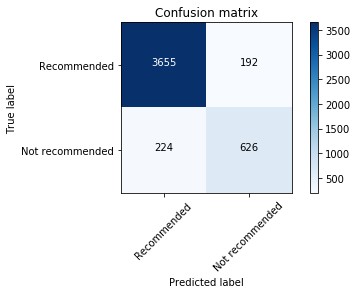

In [35]:
cm = confusion_matrix(y, pred_class)
plot_confusion_matrix(cm, ['Recommended', 'Not recommended'])